In [1]:
import os
import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle
# NOTE: THE WORDCLOUD PACKAGE ISN'T WORKING FOR SOME VERSIONS OF PYTHON.
# LOCKING PYTHON VERSION TO 3.7 BECAUSE OF THAT.
from wordcloud import WordCloud
import spacy
import spacy_transformers
import torch

In [71]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [3]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [5]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [6]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [7]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [8]:
LOAD_CLUSTERS_DATA = True

In [9]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [10]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [11]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [12]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [13]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [14]:
def get_user_followers(user_name, user_id, num_pages=1):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [15]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [16]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [17]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
for cluster in russia_sources_rus:
    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_rus:
    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_ukr:
    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

for cluster in ukraine_sources_eng:
    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nfor cluster in russia_sources_rus:\n    rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_rus:\n    ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_ukr:\n    ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\nfor cluster in ukraine_sources_eng:\n    ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [18]:
# TEST CODE: 1000 followers per cluster, 2 cluster per each
for i in range(0, 2):
    rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

for i in range(0, 2):
    ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [19]:
print(ukr_eng_cluster_followers)

[(('@dmitry_gordon', 1334400780), [<User id=1598870685149011969 name=Geka Rams username=RamsGeka1>, <User id=1598864011684110336 name=Ірина Шенгелія username=SengeliaIrina>, <User id=1577271398292197376 name=Olha username=OlhaKasian>, <User id=1584031695917006850 name=mr.S username=1loveCheeese>, <User id=1598819728348307458 name=John username=John147309561>, <User id=1598814547921567747 name=Субхон Марупов username=MarupovSubhon>, <User id=1598813448061833216 name=tomixs78 username=tomixs781>, <User id=1499793187489128452 name=Vladas Stabingis username=VladasStamata>, <User id=1254430907928317954 name=Elena username=Elena47053563>, <User id=1583195036342165507 name=Dagger Paws Mafia Clan username=DaggerPawsMC>, <User id=1598805180841173005 name=V P username=VP1304>, <User id=1598763105433026580 name=Vygantas Talmantas username=VTalmantas>, <User id=1598742390625505291 name=MARTINA GIRL username=MARTINAGIRL4>, <User id=1572515538739265537 name=Олег Фененко username=Fenol76>, <User id=1

In [20]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

"\nprint(type(followers[('@minregion_ua', 3333475643)][0]))\nprint(followers[('@minregion_ua', 3333475643)][0].name)\nprint(followers[('@minregion_ua', 3333475643)][0].id)\n"

In [21]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [22]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [23]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [24]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [25]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [26]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,Geka Rams,1598870685149011969
1,Ірина Шенгелія,1598864011684110336
2,Olha,1577271398292197376
3,mr.S,1584031695917006850
4,John,1598819728348307458
...,...,...
994,Ирина Карева,1384785936794411008
995,Igor Mindru,1595485183620399116
996,Liudmyla Vashchenkova,1496743524284436482
997,elizaveta,1595477467904593922


In [27]:
import networkx as nx

In [28]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [29]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [30]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [31]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

In [32]:
print(global_graph_pd.size)
print(set(global_graph_pd['cluster_name']))

12000
{'@SvobodaRadio', '@ru_rbc'}


In [33]:
global_graph_pd_columns = list(global_graph_pd.columns)

In [34]:
print("Constructing NetworkX graph")

# what if you store all attributes as edge attributes?
G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', edge_attr = global_graph_pd_columns,
                             create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


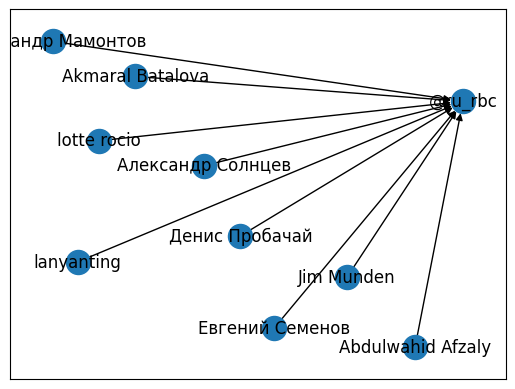

In [35]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)

<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [36]:
def get_edge_attributes(graph, attr_list):
    KEY = 0
    VALUE = 1
    edge_attrs = {}
    for attr in attr_list:
        edges_attribute = nx.get_edge_attributes(graph, attr)
        for edge_attr in edges_attribute.items():
            if edge_attr[KEY] in edge_attrs.keys():
                edge_attr_values = edge_attrs[edge_attr[KEY]]
                edge_attr_values.append(edge_attr[VALUE])
                edge_attrs[edge_attr[KEY]] = edge_attr_values
            else:
                edge_attrs[edge_attr[KEY]] = [edge_attr[VALUE]]
    return edge_attrs

edge_attrs = get_edge_attributes(subgraph, global_graph_pd_columns)

print(edge_attrs)

{('Евгений Семенов', '@ru_rbc'): ['Евгений Семенов', 1598857453986275328, '@ru_rbc', 269770723, 535754, 0], ('Денис Пробачай', '@ru_rbc'): ['Денис Пробачай', 1598879915537055744, '@ru_rbc', 269770723, 535754, 0], ('Akmaral Batalova', '@ru_rbc'): ['Akmaral Batalova', 1446145902566068225, '@ru_rbc', 269770723, 535754, 0], ('Александр Мамонтов', '@ru_rbc'): ['Александр Мамонтов', 1598862790428692480, '@ru_rbc', 269770723, 535754, 0], ('Jim Munden', '@ru_rbc'): ['Jim Munden', 1542280890075815937, '@ru_rbc', 269770723, 535754, 0], ('lotte rocio', '@ru_rbc'): ['lotte rocio', 1209855393263951872, '@ru_rbc', 269770723, 535754, 0], ('Abdulwahid Afzaly', '@ru_rbc'): ['Abdulwahid Afzaly', 1592361793921359872, '@ru_rbc', 269770723, 535754, 0], ('Александр Солнцев', '@ru_rbc'): ['Александр Солнцев', 1598871618188722176, '@ru_rbc', 269770723, 535754, 0], ('lanyanting', '@ru_rbc'): ['lanyanting', 1582264187132297216, '@ru_rbc', 269770723, 535754, 0]}


In [37]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

Running analysis on the network...


In [38]:
import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G), key=len,
                             reverse=True)

In [39]:
print("The number of communities detected is ", len(twitter_communities))

The number of communities detected is  2


In [40]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [41]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [42]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

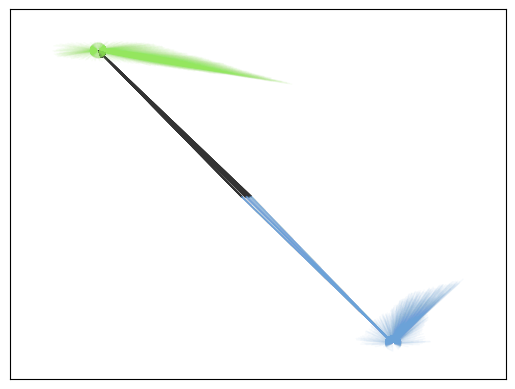

In [43]:
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

In [44]:
all_clusters = []

all_clusters.extend(rus_cluster)
all_clusters.extend(ukr_eng_cluster)
all_clusters.extend(ukr_rus_cluster)
all_clusters.extend(ukr_ukr_cluster)

all_clusters_dict = {}

for cluster in all_clusters:
    if str(cluster[0]) in G.nodes:
        all_clusters_dict[str(cluster[0])] = str(cluster[0])

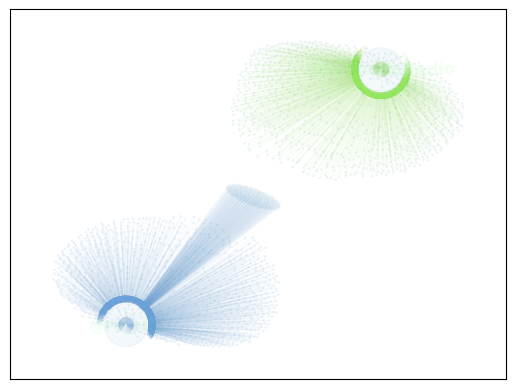

In [45]:
# TODO: ADD CLUSTER LABELS TO THE VISUALIZATION BELOW
pos = nx.spring_layout(G, k=0.15)

G_node_degrees = dict(G.degree)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=[v * 1 for v in G_node_degrees.values()],
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=True, label='Group Follower Clusters',
    labels=all_clusters_dict, font_color='#00ff00', font_weight='bold')

In [46]:
def sort_graph_by_deg_desc(graph):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

In [47]:
G_deg_sorted = sort_graph_by_deg_desc(G)

In [48]:
print("Performing connectivity analysis on a graph")

node_connections = nx.all_pairs_node_connectivity(subgraph)

Performing connectivity analysis on a graph


In [49]:
def get_shared_nodes_within_group(node_connections, group_members):
    shared_connections = []
    for username, connections_dict in node_connections.items():
        for group_member in group_members:
            if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                shared_connections.append(username)
    return shared_connections

In [50]:
get_shared_nodes_within_group(node_connections, rus_cluster)

[]

In [51]:
def get_shared_nodes_between_groups(node_connections, cluster_groups):
    shared_connections = {}
    for username, connections_dict in node_connections.items():
        for group_name, group_members in cluster_groups.items():
            for group_member in group_members:
                if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                    if group_name not in shared_connections.keys():
                        shared_connections.append(username)
                    else:
                        shared_connections[group_name] = shared_connections[group_name].append(username)
    return shared_connections

In [52]:
TWITTER_CLUSTER_GROUPS = {
    "rus_cluster": russia_sources_rus,
    "ukr_eng_cluster": ukraine_sources_rus,
    "ukr_rus_cluster": ukraine_sources_ukr,
    "ukr_ukr_cluster": ukraine_sources_eng
}

In [53]:
shared_connections_between_groups = get_shared_nodes_between_groups\
(node_connections, TWITTER_CLUSTER_GROUPS)

In [54]:
shared_connections_between_groups

{}

In [55]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

"\nimport matplotlib.pyplot as plt\n\nf, ax = plt.subplots(figsize=(10, 10))\nplt.style.use('ggplot')\nnodes = nx.draw_networkx_nodes(G, pos,\n                               alpha=0.8)\nnodes.set_edgecolor('k')\nnx.draw_networkx_labels(G, pos, font_size=8)\nnx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)\n"

In [56]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [57]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group

<h2>Visualizing the Network using Neo4j</h2>

<h2>Analyzing group sentiments</h2>

In [58]:
# NOTE: THIS FUNCTION PULLS THE TWEETS MENTIONING A PARTICULAR USER, NOT FROM
# A PARTICULAR USER

def get_user_tweet_mentions(username, num_tweets, entities=None):

    search_query = username + " OR "

    if entities is not None:
        # include all possible candidate names in a query
        for entity in entities:
            search_query += "entity:" + '"' + entity + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               tweet_mode="extended")

    return tweets

In [59]:
def get_user_tweets(user_id, num_tweets):

    # https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
    # https://docs.tweepy.org/en/stable/expansions_and_fields.html#expansions-parameter
    # https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

    tweets = client.get_users_tweets(id = user_id, max_results = num_tweets,
                               exclude = ['retweets'], expansions='entities.mentions.username')

    return tweets

In [60]:
# Sentiment in relation to a different group

# Tweets word Cloud

# Tweets HashTags Word Cloud

# Tweets events mapping? (Maybe)

In [61]:
# https://www.caida.org/catalog/software/walrus/

In [62]:
print("Pulling a sample of tweets for all clusters")

NUM_TWEETS = 5
USERNAME_IDX = 0
USER_ID_IDX = 1

cluster_tweets = {}

for cluster in all_clusters:
    cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

Pulling a sample of tweets for all clusters


In [63]:
cluster_tweets

{('@1tvru_news',
  160881696): Response(data=[<Tweet id=1598768750479687685 text='Украинская православная церковь попала под удар президента Зеленского, утвердившего решение Совбеза о религиозных организациях. Под санкциями — их список не опубликован — около десятка священнослужителей.  https://t.co/NUtMIjeI3t https://t.co/cvdcYvjTZz'>, <Tweet id=1598763072759267328 text='Запад пытается создать еще одну антироссийскую структуру, маскируя ее под судебную инстанцию. Так сегодня наш МИД отозвался об идее Франции учредить некий «специальный трибунал по преступлениям агрессии России»: https://t.co/t2uBaIHgkR https://t.co/FGRPLgKHJz'>, <Tweet id=1598757330220220416 text='Майору Егибеку Егибекову, начальнику группы центра «Лидер» МЧС, сегодня вручен орден Мужества. Награда из рук главы ведомства Александра Куренкова в Главном военном клиническом госпитале https://t.co/YY4ieLNTmM https://t.co/LoXyHK3bN1'>, <Tweet id=1598670772301492225 text='Новый ракетный удар по мирным жителям Донецка. В сет

In [64]:
def convert_tweets_to_json(raw_tweets_dict):
    json_tweets = []
    for username, tweets in raw_tweets_dict.items():
        for tweet in tweets:
            json_tweet_str = json.dumps(tweet.text)
            json_tweet = json.loads(json_tweet_str)
            json_tweets.append(json_tweet)
    return json_tweets

In [65]:
tweet_status = api.get_status(1598709448129662977)

print(tweet_status._json)

{'created_at': 'Fri Dec 02 16:03:29 +0000 2022', 'id': 1598709448129662977, 'id_str': '1598709448129662977', 'text': 'На канале "В гостях у Гордона" транслируется стрим главного редактора интернет-издания "#ГОРДОН" Алеси #Бацман с те… https://t.co/ta77zbvZLc', 'truncated': True, 'entities': {'hashtags': [{'text': 'ГОРДОН', 'indices': [88, 95]}, {'text': 'Бацман', 'indices': [103, 110]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ta77zbvZLc', 'expanded_url': 'https://twitter.com/i/web/status/1598709448129662977', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1334400780, 'id_str': '1334400780', 'name': 'Дмитрий Гордон', 'screen_name': 'dmitry_gordon', 'location': 'Украина', 'descri

In [66]:
cluster_tweets

{('@1tvru_news',
  160881696): Response(data=[<Tweet id=1598768750479687685 text='Украинская православная церковь попала под удар президента Зеленского, утвердившего решение Совбеза о религиозных организациях. Под санкциями — их список не опубликован — около десятка священнослужителей.  https://t.co/NUtMIjeI3t https://t.co/cvdcYvjTZz'>, <Tweet id=1598763072759267328 text='Запад пытается создать еще одну антироссийскую структуру, маскируя ее под судебную инстанцию. Так сегодня наш МИД отозвался об идее Франции учредить некий «специальный трибунал по преступлениям агрессии России»: https://t.co/t2uBaIHgkR https://t.co/FGRPLgKHJz'>, <Tweet id=1598757330220220416 text='Майору Егибеку Егибекову, начальнику группы центра «Лидер» МЧС, сегодня вручен орден Мужества. Награда из рук главы ведомства Александра Куренкова в Главном военном клиническом госпитале https://t.co/YY4ieLNTmM https://t.co/LoXyHK3bN1'>, <Tweet id=1598670772301492225 text='Новый ракетный удар по мирным жителям Донецка. В сет

In [67]:
TWEETS_DIR = 'tweets/'

def tweets_to_df(raw_tweets_dict):
    tweets_df = pd.DataFrame(
        {
            'Cluster Username' : pd.Series(dtype='str'),
            'Cluster ID' : pd.Series(dtype='int'),
            'Tweet Text' : pd.Series(dtype='str')
        }
    )
    for username, tweets in raw_tweets_dict.items():
            for tweet in tweets.data:
                new_df_row = {
                    'Cluster Username' : username[0],
                    'Cluster ID' : username[1],
                    'Tweet Text' : str(tweet)
                }
                tweets_df = tweets_df.append(new_df_row, ignore_index=True)
    return tweets_df

def tweets_df_to_csv(tweets_df):
    tweets_df.to_csv(TWEETS_DIR + 'tweets.csv', index=False)
    return

In [68]:
tweets_df = tweets_to_df(cluster_tweets)
tweets_df_to_csv(tweets_df)

<h2>Processing Collected Tweets Before Visualizing them</h2>

In [69]:
def get_sentiment(tweets_df):
    tweet_tokens_dict = {}
    for _, row in tweets_df.iterrows():

    return

IndentationError: expected an indented block (3969050516.py, line 5)

In [ ]:
print("Use this function to clean the tweet's body")

def clean_tweet(tweet_body):
    # remove @ mentions from the tweet
    text = re.sub(r'@[A-Za-z0-9]+', '', tweet_body)
    # remove the hashtags from tweets
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

<h2>Visualizing Tweet Content using Word Cloud</h2>

In [ ]:
get_all_tokens(tweets_df)

In [ ]:
def create_wordcloud(tweets_df):
    dem_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(all_democrat_candidates_tokens)

<h2>Performing Entity Recognition and Sentiment Analysis for different
groups of tweets</h2>

In [ ]:
print("Loading NLP libraries for English, Ukrainian and Russian languages")

In [272]:
!python3 -m spacy download en_core_web_sm

nlp_eng = spacy.load('en_core_web_sm')

     |████████████████████████████████| 460.3 MB 30 kB/s              
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
     |████████████████████████████████| 12.8 MB 17.8 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [276]:
!python3 -m spacy download uk_core_news_sm

nlp_ukr = spacy.load('uk_core_news_sm')

     |████████████████████████████████| 14.9 MB 65 kB/s             
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')


In [277]:
!python3 -m spacy download ru_core_news_sm

nlp_rus = spacy.load('ru_core_news_sm')

     |████████████████████████████████| 15.3 MB 13.8 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [75]:
# Spacy has vocabulary for English, Ukrainian and Russian languages

text = ("Восемь вандалов, которые срезали со стены дома в #Гостомеле женщину "
        "в противогазе авторства #Бэнкси, дали показания полиции #Украина #россия #ВСУ #война #агрессияроссии #вторжениероссии #stoprussia # #войнасукраиной #Войнапутина")

doc = nlp_rus(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text)
    print(entity.text, entity.label_)

NameError: name 'nlp_rus' is not defined

In [73]:
print("Performing sentiment analysis on tweets")

analyzer = SentimentIntensityAnalyzer()

analyzer.polarity_scores("Вейдер очень умный, красивый и смешной!!!")

Performing sentiment analysis on tweets


{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.882}

In [76]:
analyzer.polarity_scores("Восемь вандалов, которые срезали со стены дома в #Гостомеле женщину "
        "в противогазе авторства #Бэнкси, дали показания полиции #Украина #россия #ВСУ #война #агрессияроссии #вторжениероссии #stoprussia # #войнасукраиной #Войнапутина")

{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'compound': -0.2732}